# Predicting Diabetes Hospital Readmission

## Overview
This project aims to create a binary classification model to predict whether or not a diabetes patient who was admitted to the hospital will be readmitted. This predictive model can help healthcare providers identify high-risk patients early, enabling targeted interventions and improving care management. This analysis can also help identify key risk factors that contribute to hospital readmissions among diabetes patients. Ultimately, the goal is to reduce avoidable readmissions, optimize hospital resources, and support data-driven decision-making in healthcare settings.

## Variables Table

| **Variable**              | **Description**                                                                 |
|---------------------------|---------------------------------------------------------------------------------|
| encounter_id              | Unique identifier of an encounter                                              |
| patient_nbr               | Unique identifier of a patient                                                 |
| race                      | Values include Caucasian, Asian, African American, Hispanic, and other         |
| gender                    | Values include male, female, and unknown/invalid                               |
| age                       | Grouped in 10-year intervals from 0–100                                        |
| weight                    | Weight in pounds                                                               |
| admission_type_id         | Integer identifier corresponding to 9 distinct values (e.g., emergency, urgent, elective) |
| discharge_disposition_id  | Integer identifier corresponding to 29 distinct values (e.g., discharged to home, expired, not available) |
| admission_source_id       | Integer identifier corresponding to 21 distinct values (e.g., physician referral, emergency room, transfer from a hospital) |
| time_in_hospital          | Integer number of days between admission and discharge                         |
| payer_code                | Integer identifier corresponding to 23 distinct values (e.g., Blue Cross/Blue Shield, Medicare, self-pay) |
| medical_specialty         | Integer identifier of the admitting physician’s specialty; 84 values (e.g., cardiology, internal medicine, surgeon) |
| num_lab_procedures        | Number of lab tests performed during the encounter                             |
| num_procedures            | Number of procedures (other than lab tests) performed during the encounter     |
| num_medications           | Number of distinct generic names administered during the encounter             |
| number_outpatient         | Number of outpatient visits of the patient in the year preceding the encounter |
| number_inpatient          | Number of inpatient visits of the patient in the year preceding the encounter  |
| diag_1                    | Primary diagnosis (first 3 digits of ICD-9); 848 distinct values               |
| diag_2                    | Secondary diagnosis (first 3 digits of ICD-9); 923 distinct values             |
| diag_3                    | Additional secondary diagnosis (first 3 digits of ICD-9); 954 distinct values  |
| number_diagnoses          | Number of diagnoses entered to the system                                      |
| max_glu_serum             | Max glucose serum levels; values: >200, >300, normal, or none if not measured  |
| A1Cresult                 | Hemoglobin A1c test result; values: >7, >8, normal, or none if not measured     |
| change                    | Indicates if there was a change in diabetic medications (dosage or generic)    |
| diabetesMed              | Indicates if any diabetic medication was prescribed                            |
| readmitted                | Days to inpatient readmission                                                  |

There are also variables corresponding to different diabetes medication, and their values indicate whether they started taking more of the medication on that encounter (up), less (down), neither (steady), or if they are not taking that medication. The medications include metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone.

## Dependencies
Import all required libraries.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from tabulate import tabulate
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, recall_score, classification_report, roc_auc_score,
                             mean_squared_error, roc_curve, auc, precision_score, precision_recall_curve)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Data
Loading and preprocessing the dataset.

In [3]:
# Data
diabetes = pd.read_csv('data/Diabetes_Data_1999_2008.csv', na_values=[], keep_default_na=False)
id_mapping = pd.read_csv('data/id_mapping.csv')

In [4]:
# Look at column names and data types
column_names = diabetes.dtypes.reset_index()
column_names.columns = ['Column Names', 'Data Type']
column_names = tabulate(column_names, headers='keys', tablefmt='pretty')
print(column_names)

+----+--------------------------+-----------+
|    |       Column Names       | Data Type |
+----+--------------------------+-----------+
| 0  |       encounter_id       |   int64   |
| 1  |       patient_nbr        |   int64   |
| 2  |           race           |  object   |
| 3  |          gender          |  object   |
| 4  |           age            |  object   |
| 5  |          weight          |  object   |
| 6  |    admission_type_id     |   int64   |
| 7  | discharge_disposition_id |   int64   |
| 8  |   admission_source_id    |   int64   |
| 9  |     time_in_hospital     |   int64   |
| 10 |        payer_code        |  object   |
| 11 |    medical_specialty     |  object   |
| 12 |    num_lab_procedures    |   int64   |
| 13 |      num_procedures      |   int64   |
| 14 |     num_medications      |   int64   |
| 15 |    number_outpatient     |   int64   |
| 16 |     number_emergency     |   int64   |
| 17 |     number_inpatient     |   int64   |
| 18 |          diag_1          | 

In [5]:
# Summary statistics for numeric variables
diabetes.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


## Data Cleaning

In [6]:
# Check if there are any duplicate encounters for one patient
print(len(diabetes))
print(diabetes['patient_nbr'].nunique() / len(diabetes))

101766
0.7027690977340173


In [7]:
# Only include the first encounter for each patient
diabetes = diabetes.drop_duplicates(subset = ['patient_nbr'], keep = 'first')
len(diabetes)

71518

In [8]:
# Mapping IDs to actual values for admission, discharge disposition, and admission source

## Admission_type_id
admission_type_id_map = {
    1:'Emergency', 
    2:'Urgent', 
    3:'Elective', 
    4:'Newborn', 
    5:'Not Available', 
    6:'Null', 
    7:'Trauma Center', 
    8:'Not Mapped'
}
diabetes['admission_type_id'] = diabetes['admission_type_id'].map(admission_type_id_map)

## Discharge_disposition_id
discharge_disposition_id_map = {
    1: 'Discharged to home',
    2: 'Transferred to short-term hospital',
    3: 'Transferred to SNF',
    4: 'Transferred to ICF',
    5: 'Transferred to inpatient care',
    6: 'Home with health service',
    7: 'Left AMA',
    8: 'Home under IV care',
    9: 'Admitted to this hospital',
    10: 'Neonate to another hospital',
    11: 'Expired',
    12: 'Still patient or outpatient',
    13: 'Hospice at home',
    14: 'Hospice at facility',
    15: 'Transferred to Medicare swing bed',
    16: 'Referred to outpatient services',
    17: 'Referred within institution',
    18: 'NULL',
    19: 'Expired at home (Medicaid, hospice)',
    20: 'Expired in facility (Medicaid, hospice)',
    21: 'Expired, unknown (Medicaid, hospice)',
    22: 'Transferred to rehab facility',
    23: 'Transferred to long-term care',
    24: 'Transferred to Medicaid-only nursing',
    25: 'Not Mapped',
    26: 'Unknown/Invalid',
    27: 'Transferred to federal facility',
    28: 'Transferred to psychiatric hospital',
    29: 'Transferred to Critical Access Hospital',
    30: 'Transferred to Other Health institution'
}
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].map(discharge_disposition_id_map)

# Admission_source_id
admission_source_id_map = {
    1: 'Physician Referral',
    2: 'Clinic Referral',
    3: 'HMO Referral',
    4: 'Transfer from Hospital',
    5: 'Transfer from SNF',
    6: 'Transfer from Health Facility',
    7: 'Emergency Room',
    8: 'Court/Law Enforcement',
    9: 'Not Available',
    10: 'Transfer from Critical Access Hospital',
    11: 'Normal Delivery',
    12: 'Premature Delivery',
    13: 'Sick Baby',
    14: 'Extramural Birth',
    15: 'Not Available',
    17: 'NULL',
    18: 'Transfer from Home Health Agency',
    19: 'Readmission to Same Home Health Agency',
    20: 'Not Mapped',
    21: 'Unknown/Invalid',
    22: 'Transfer from Hospital (Separate Claim)',
    23: 'Born Inside Hospital',
    24: 'Born Outside Hospital',
    25: 'Transfer from Ambulatory Surgery Center',
    26: 'Transfer from Hospice'
}
diabetes['admission_source_id'] = diabetes['admission_source_id'].map(admission_source_id_map)

In [9]:
# Check for null values
sum(diabetes.isnull().mean())

0.0

In [10]:
# No explicitly null values, but noticed there were some '?' in the data
# See percentage of '?' for columns
cols_missing_values = {}
for i in diabetes.columns:
    if sum(diabetes[i].isin(['?'])) != 0: # seeing if there are any ?s
        percentage_missing = sum(diabetes[i].isin(['?'])) / diabetes.shape[0]
        cols_missing_values[i] = percentage_missing
cols_missing_values

{'race': 0.027237898151514305,
 'weight': 0.960107944853044,
 'payer_code': 0.434058558684527,
 'medical_specialty': 0.4820744427976174,
 'diag_1': 0.0001538074330937666,
 'diag_2': 0.0041108532117788525,
 'diag_3': 0.017128555049078554}

In [11]:
# Check values in max_glu_serum
diabetes['max_glu_serum'].value_counts() / diabetes.shape[0]

max_glu_serum
None    0.951677
Norm    0.024204
>200    0.013549
>300    0.010571
Name: count, dtype: float64

In [12]:
# Drop weight (96.8% missing)
# Drop max_glu_serum (94.75% not measured)
# Drop medical_specialty (49.08% missing)
# Drop payer code (40% missing)
diabetes = diabetes.drop(['weight', 'max_glu_serum', 'medical_specialty', 'payer_code'], axis = 1)

In [13]:
# Check values in gender
diabetes['gender'].value_counts()

gender
Female             38025
Male               33490
Unknown/Invalid        3
Name: count, dtype: int64

In [14]:
# Drop the 3 rows with with 'Unknown/Invalid' gender
diabetes = diabetes[diabetes['gender'] != 'Unknown/Invalid']

In [15]:
# Drop ID information
diabetes = diabetes.drop(columns = ['encounter_id', 'patient_nbr'])

## Feature Engineering
I will walk through the columns one by one, and decide what to do with each based on its type, distribution, and relevance to prediction. These are only the categorical columns - I look at the numeric variables through visualizations of their distributions in the next section. 

In [16]:
# List of categorical column names
diabetes.select_dtypes(include=['object', 'category']).columns.tolist()

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'diag_1',
 'diag_2',
 'diag_3',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [17]:
# Check distribution of categories for race
diabetes['race'].value_counts()

race
Caucasian          53491
AfricanAmerican    12887
?                   1946
Hispanic            1517
Other               1177
Asian                497
Name: count, dtype: int64

In [18]:
# Combine '?' and 'Other' columns
diabetes['race'] = diabetes['race'].replace('?', 'Other')

In [19]:
# Replace 'age' with lower bound of interval - turning into discrete numeric instead of categorical
diabetes = diabetes.copy()
diabetes['age'] = diabetes['age'].astype(str)
diabetes['age'] = diabetes['age'].str.extract(r'(\d+)').astype(int)

In [20]:
# Check distrubtion of categories for 'admission_type_id'
diabetes['admission_type_id'].value_counts()

admission_type_id
Emergency        36488
Elective         13916
Urgent           13028
Null              4588
Not Available     3174
Not Mapped         291
Trauma Center       21
Newborn              9
Name: count, dtype: int64

In [21]:
# Group any unknown and small categories
diabetes['admission_type_id'] = diabetes['admission_type_id'].replace(['Null', 'Not Available', 'Not Mapped', 'Trauma Center', 'Newborn', 'Other'], 'Other')

In [22]:
# Final 'admission_type' values
diabetes['admission_type_id'].value_counts()

admission_type_id
Emergency    36488
Elective     13916
Urgent       13028
Other         8083
Name: count, dtype: int64

In [23]:
# Check distrubtion of categories for 'discharge_disposition_id'
diabetes['discharge_disposition_id'].value_counts()

discharge_disposition_id
Discharged to home                         44315
Transferred to SNF                          8784
Home with health service                    8289
NULL                                        2474
Transferred to short-term hospital          1539
Transferred to rehab facility               1409
Expired                                     1077
Transferred to inpatient care                913
Not Mapped                                   778
Transferred to ICF                           541
Left AMA                                     409
Transferred to long-term care                260
Hospice at home                              243
Hospice at facility                          218
Transferred to psychiatric hospital           90
Home under IV care                            73
Transferred to Medicare swing bed             40
Transferred to Medicaid-only nursing          25
Admitted to this hospital                      9
Referred within institution                 

In [24]:
# Getting rid of anyone who died - they will not be readmitted to the hospital
diabetes = diabetes[~diabetes['discharge_disposition_id'].isin(['Expired',
                                                                'Expired at home (Medicaid, hospice)',
                                                                'Expired in facility (Medicaid, hospice)'])]

In [25]:
# Group together similar categories
home_health_service = ['Home with health service', 'Home under IV care']
transfer = ['Transferred to SNF',
            'Transferred to short-term hospital',
            'Transferred to rehab facility',
            'Transferred to inpatient care',
            'Transferred to ICF',
            'Transferred to long-term care',
            'Transferred to psychiatric hospital',
            'Transferred to Medicare swing bed',
            'Transferred to Medicaid-only nursing',
            'Transferred to federal facility']
hospice = ['Hospice at home', 
           'Hospice at facility']
other = ['NULL', 
         'Not Mapped',
         'Left AMA',
         'Admitted to this hospital',
         'Referred within institution',
         'Referred to outpatient services',
         'Neonate to another hospital',
         'Still patient or outpatient']
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(home_health_service, 'Home with health service')
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(transfer, 'Transfer')
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(hospice, 'Hospice')
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(other, 'Other')

In [26]:
# Final 'admission_type' values
diabetes['discharge_disposition_id'].value_counts()

discharge_disposition_id
Discharged to home          44315
Transfer                    13604
Home with health service     8362
Other                        3689
Hospice                       461
Name: count, dtype: int64

In [27]:
# Check distrubtion of categories for 'admission_source_id'
diabetes['admission_source_id'].value_counts()

admission_source_id
Emergency Room                             37561
Physician Referral                         21848
NULL                                        4858
Transfer from Hospital                      2541
Transfer from Health Facility               1788
Clinic Referral                              909
Transfer from SNF                            514
Not Mapped                                   153
HMO Referral                                 136
Not Available                                 95
Court/Law Enforcement                         11
Transfer from Critical Access Hospital         7
Transfer from Hospital (Separate Claim)        4
Extramural Birth                               2
Transfer from Ambulatory Surgery Center        2
Normal Delivery                                1
Sick Baby                                      1
Name: count, dtype: int64

In [28]:
# Group similar categories
transfer = ['Transfer from Hospital', 
            'Transfer from Health Facility', 
            'Transfer from SNF', 
            'Transfer from Hospital (Separate Claim)',
            'Transfer from Critical Access Hospital',
            'Transfer from Ambulatory Surgery Center']
null = ['NULL', 
        'Not Mapped', 
        'Not Available']
other = ['Clinic Referral', 
         'HMO Referral', 
         'Court/Law Enforcement',
         'Extramural Birth',
         'Normal Delivery',
         'Sick Baby']
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(transfer, 'Transfer')
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(other, 'Other')
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(null, 'Null')

In [29]:
# Final 'admission_source' values
diabetes['admission_source_id'].value_counts()

admission_source_id
Emergency Room        37561
Physician Referral    21848
Null                   5106
Transfer               4856
Other                  1060
Name: count, dtype: int64

In [30]:
# Rename id columns because they are not ids anymore
diabetes = diabetes.rename(columns={'admission_type_id': 'admission_type', 'admission_source_id': 'admission_source', 'discharge_disposition_id': 'discharge_disposition'})

In [31]:
# Map ICD9 codes to their category
icd9_mapping = {
    (1, 139): 'Infectious and parasitic diseases',
    (140, 239): 'Neoplasms',
    (240, 279): 'Endocrine, nutritional and metabolic diseases',
    (280, 289): 'Diseases of the blood and blood-forming organs',
    (290, 319): 'Mental disorders',
    (320, 389): 'Diseases of the nervous system and sense organs',
    (390, 459): 'Diseases of the circulatory system',
    (460, 519): 'Diseases of the respiratory system',
    (520, 579): 'Diseases of the digestive system',
    (580, 629): 'Diseases of the genitourinary system',
    (630, 679): 'Complications of pregnancy, childbirth, and puerperium',
    (680, 709): 'Diseases of the skin and subcutaneous tissue',
    (710, 739): 'Diseases of the musculoskeletal system and connective tissue',
    (740, 759): 'Congenital anomalies',
    (760, 779): 'Certain conditions originating in the perinatal period',
    (780, 799): 'Symptoms, signs, and ill-defined conditions',
    (800, 999): 'Injury and poisoning',
    ('E', 'V'): 'External causes of injury and supplemental classification'
}

def map_icd9_to_category(code):
    """
    Map ICD9 codes to their category
    """
    if isinstance(code, str): 
        if code.startswith('E') or code.startswith('V'):
            return icd9_mapping[('E', 'V')]
    try:
        numeric_code = float(code)
        for (low, high), category in icd9_mapping.items():
            if low <= numeric_code <= high:
                return category
    except ValueError:
        return code

diabetes['diag_1'] = diabetes['diag_1'].apply(map_icd9_to_category)
diabetes['diag_2'] = diabetes['diag_2'].apply(map_icd9_to_category)
diabetes['diag_3'] = diabetes['diag_3'].apply(map_icd9_to_category)

In [32]:
def cum_sum_table(column):
    """
    Show the proportion and cumulative sum for values in a column
    """
    proportions = diabetes[column].value_counts() / diabetes.shape[0]
    cumulative_proportions = proportions.cumsum()
    diag_1_summary = pd.DataFrame({
        'Proportion': proportions,
        'Cumulative Proportion': cumulative_proportions})
    return diag_1_summary

In [33]:
# Look at distribution for 'diag_1'
cum_sum_table('diag_1')

,Proportion,Cumulative Proportion
diag_1,,
Diseases of the circulatory system,0.304213,0.304213
"Endocrine, nutritional and metabolic diseases",0.108305,0.412517
Diseases of the respiratory system,0.092644,0.505161
Diseases of the digestive system,0.090117,0.595278
"Symptoms, signs, and ill-defined conditions",0.078304,0.673581
Injury and poisoning,0.066760,0.740342
Diseases of the musculoskeletal system and connective tissue,0.057801,0.798143
Diseases of the genitourinary system,0.048998,0.847141
Neoplasms,0.037739,0.884880


In [34]:
# Limiting diag_1 to top 10 diagnoses
top_10_diag = diabetes['diag_1'].value_counts(normalize=True).head(10).index.tolist()
diabetes['diag_1'] = diabetes['diag_1'].apply(lambda x: x if x in top_10_diag else 'Other')

In [35]:
# Look at distribution for 'diag_2'
cum_sum_table('diag_2')

,Proportion,Cumulative Proportion
diag_2,,
Diseases of the circulatory system,0.310857,0.310857
"Endocrine, nutritional and metabolic diseases",0.218128,0.528986
Diseases of the respiratory system,0.092445,0.621431
Diseases of the genitourinary system,0.072312,0.693743
"Symptoms, signs, and ill-defined conditions",0.045207,0.738950
Diseases of the digestive system,0.038648,0.777598
Diseases of the skin and subcutaneous tissue,0.031847,0.809445
Diseases of the blood and blood-forming organs,0.029575,0.839020
Mental disorders,0.026409,0.865429


In [36]:
# Limiting diag_2 to top 10 diagnoses
top_10_diag = diabetes['diag_2'].value_counts(normalize=True).head(10).index.tolist()
diabetes['diag_2'] = diabetes['diag_2'].apply(lambda x: x if x in top_10_diag else 'Other')

In [37]:
# Look at distribution for 'diag_3'
cum_sum_table('diag_3')

,Proportion,Cumulative Proportion
diag_3,,
Diseases of the circulatory system,0.294274,0.294274
"Endocrine, nutritional and metabolic diseases",0.270279,0.564553
Diseases of the respiratory system,0.061024,0.625577
Diseases of the genitourinary system,0.054422,0.679999
External causes of injury and supplemental classification,0.050035,0.730034
"Symptoms, signs, and ill-defined conditions",0.044157,0.774190
Diseases of the digestive system,0.034956,0.809147
Mental disorders,0.030526,0.839673
Diseases of the blood and blood-forming organs,0.024591,0.864264


In [38]:
# Limiting to diag_3 top 10 diagnoses
top_10_diag = diabetes['diag_3'].value_counts(normalize=True).head(10).index.tolist()
diabetes['diag_3'] = diabetes['diag_3'].apply(lambda x: x if x in top_10_diag else 'Other')

In [39]:
# Grouping A1Cresult into measured or not measured
## Literature showing relationship between A1C measurement and readmission
diabetes['A1Cresult'] = diabetes['A1Cresult'].astype(str)
measured_A1Cresult = ['>8', 'Norm', '>7']
diabetes['A1Cresult'] = diabetes['A1Cresult'].replace(measured_A1Cresult, '1')
diabetes['A1Cresult'] = diabetes['A1Cresult'].replace('None', '0')
diabetes['A1Cresult'] = diabetes['A1Cresult'].astype(int)

In [40]:
# Replace 'Yes' with 1 and 'No' with 0 for 'change' and 'diabetesMed'
pd.set_option('future.no_silent_downcasting', True) # Avoid warnings
diabetes['change'] = diabetes['change'].astype(str)
diabetes['diabetesMed'] = diabetes['diabetesMed'].astype(str)
diabetes['change'] = diabetes['change'].replace({'No': 0, 'Ch': 1}).astype(int)
diabetes['diabetesMed'] = diabetes['diabetesMed'].replace({'No': 0, 'Yes': 1}).astype(int)

In [41]:
# Replace 'Steady', 'Up' or 'Down' as 1 (taking medicine) and 'No' as 0 (not taking medicine)
medicine = ['metformin', 
            'repaglinide', 
            'nateglinide', 
            'chlorpropamide', 
            'glimepiride',
            'acetohexamide', 
            'glipizide', 
            'glyburide', 
            'tolbutamide', 
            'pioglitazone',
            'rosiglitazone', 
            'acarbose', 
            'miglitol', 
            'troglitazone', 
            'tolazamide',
            'examide', 
            'citoglipton', 
            'insulin', 
            'glyburide-metformin',
            'glipizide-metformin', 
            'glimepiride-pioglitazone',
            'metformin-rosiglitazone', 
            'metformin-pioglitazone']
yes = ['Steady', 'Up', 'Down']
for i in medicine:
    diabetes[i] = diabetes[i].replace(yes, 1).replace('No', 0)

In [42]:
# Investigate counts and proportions for each medicine
import pandas as pd
med_usage = []
for med in medicine:
    count_1 = diabetes[med].sum()
    proportion_1 = count_1 / len(diabetes)
    med_usage.append({'Medicine': med, 'Count': count_1, 'Proportion': proportion_1})
med_usage_df = pd.DataFrame(med_usage)
med_usage_df = med_usage_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print(med_usage_df)

                    Medicine  Count  Proportion
0                    insulin  35975    0.510784
1                  metformin  14934    0.212037
2                  glipizide   9049    0.128480
3                  glyburide   7809    0.110874
4               pioglitazone   5280    0.074967
5              rosiglitazone   4675    0.066377
6                glimepiride   3713    0.052718
7                repaglinide    922    0.013091
8        glyburide-metformin    496    0.007042
9                nateglinide    493    0.007000
10                  acarbose    201    0.002854
11            chlorpropamide     71    0.001008
12                tolazamide     30    0.000426
13                  miglitol     20    0.000284
14               tolbutamide     17    0.000241
15       glipizide-metformin      7    0.000099
16              troglitazone      3    0.000043
17   metformin-rosiglitazone      2    0.000028
18             acetohexamide      1    0.000014
19    metformin-pioglitazone      1    0

In [43]:
# Include the medicines that > 5% of participants are taking and convert to integers
widely_used_medicine = med_usage_df[med_usage_df['Proportion'] >= 0.05]['Medicine'].tolist()
diabetes = diabetes.drop(columns=[med for med in medicine if med not in widely_used_medicine])
diabetes[widely_used_medicine] = diabetes[widely_used_medicine].astype(int)

In [44]:
# Final columns in dataset
diabetes.columns

Index(['race', 'gender', 'age', 'admission_type', 'discharge_disposition',
       'admission_source', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'A1Cresult', 'metformin', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'change', 'diabetesMed', 'readmitted'],
      dtype='object')

## Visualizations
Examine the distributions of all of the variables in the dataset.

In [45]:
def plot_cat(columns, rows, cols):
    """
    Plot categorical variables with bar plots
    """
    for i, col in enumerate(columns):
        plt.subplot(rows, cols, i+1)
        counts = diabetes[col].value_counts()
        plt.bar(counts.index, counts.values, color = 'lightpink', edgecolor = 'black')
        plt.title(f'Distribution of {col}')
        plt.ylabel('Count')
        plt.xticks(rotation = 45)
    plt.tight_layout()

In [46]:
# Data types of all columns
diabetes.dtypes

race                     object
gender                   object
age                       int64
admission_type           object
discharge_disposition    object
admission_source         object
time_in_hospital          int64
num_lab_procedures        int64
num_procedures            int64
num_medications           int64
number_outpatient         int64
number_emergency          int64
number_inpatient          int64
diag_1                   object
diag_2                   object
diag_3                   object
number_diagnoses          int64
A1Cresult                 int64
metformin                 int64
glimepiride               int64
glipizide                 int64
glyburide                 int64
pioglitazone              int64
rosiglitazone             int64
insulin                   int64
change                    int64
diabetesMed               int64
readmitted               object
dtype: object

In [47]:
# Identifying categorical columns
print(diabetes.select_dtypes(include=['object', 'category']).columns)

Index(['race', 'gender', 'admission_type', 'discharge_disposition',
       'admission_source', 'diag_1', 'diag_2', 'diag_3', 'readmitted'],
      dtype='object')


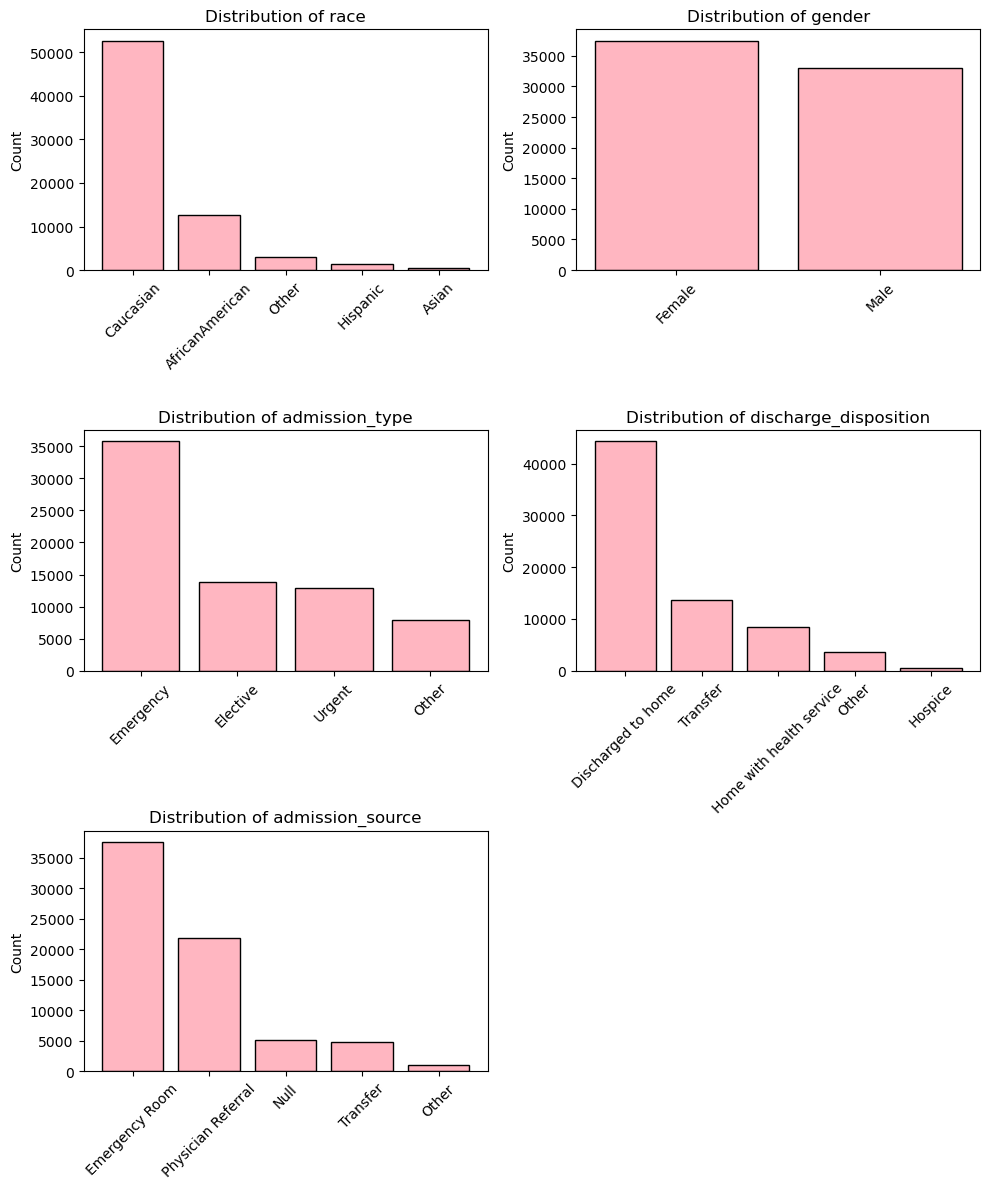

In [48]:
# Bar plots for categorical variables (not including diagoses)
categorical_columns = ['race', 'gender', 'admission_type', 'discharge_disposition', 'admission_source']
plt.figure(figsize = (10, 12))
plot_cat(categorical_columns, 3, 2)

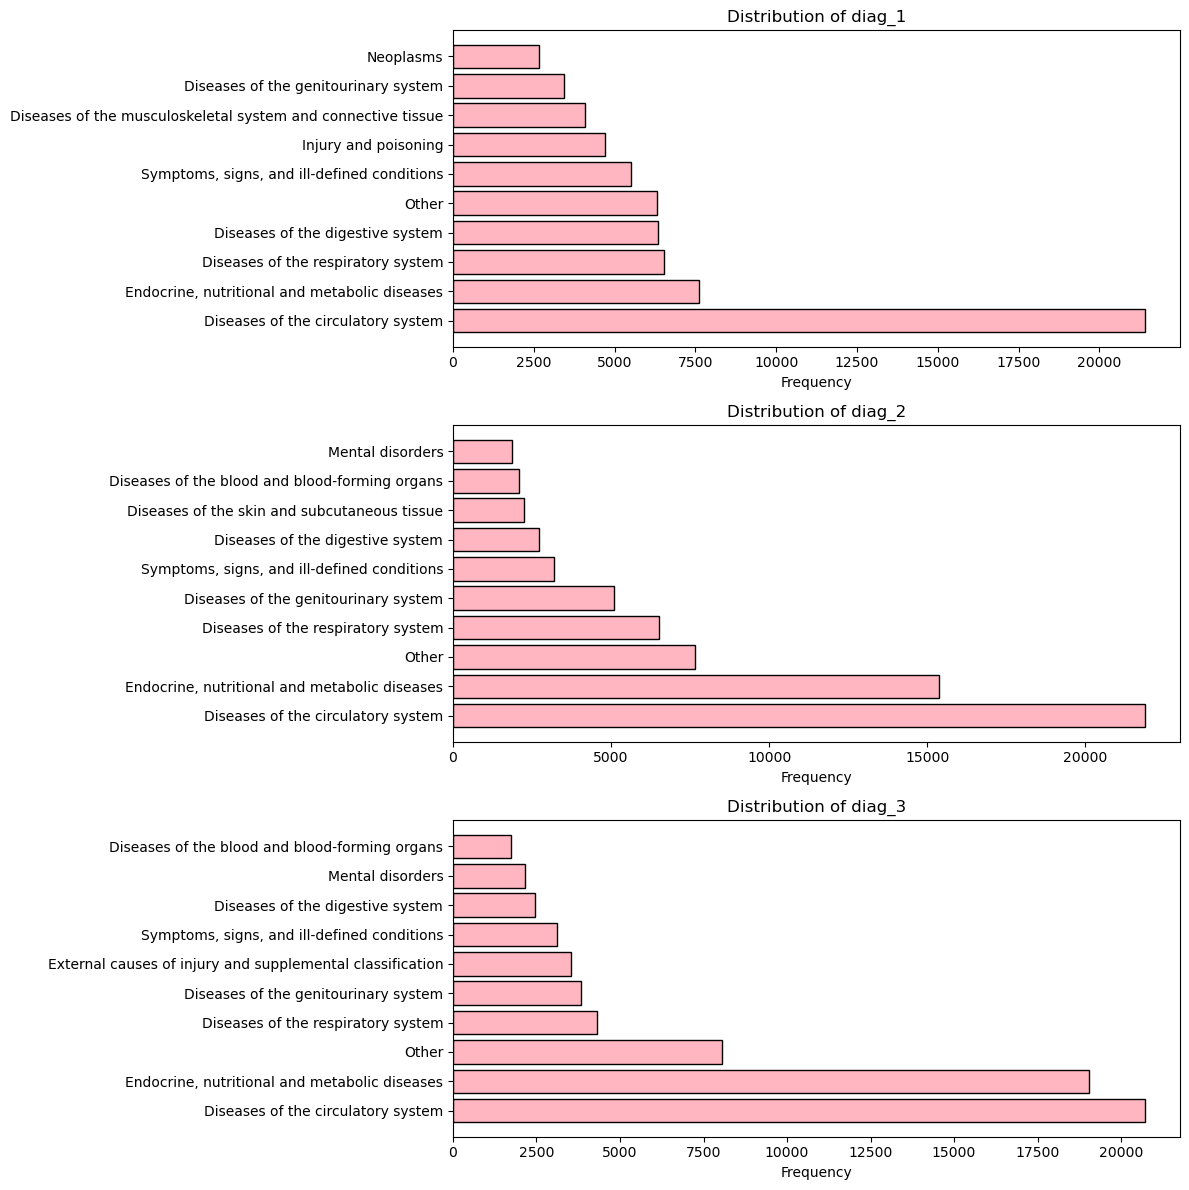

In [49]:
# Bar plots for diagnoses variables
diagnoses = ['diag_1', 'diag_2', 'diag_3']
plt.figure(figsize = (12,12))
for i, col in enumerate(diagnoses):
    plt.subplot(3, 1, i+1)
    counts = diabetes[col].value_counts().head(10)
    plt.barh(counts.index, counts.values, color = 'lightpink', edgecolor = 'black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Frequency')
plt.tight_layout()

In [50]:
# Identifying numeric columns
print(diabetes.select_dtypes(include=['int64']).columns)

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed'],
      dtype='object')


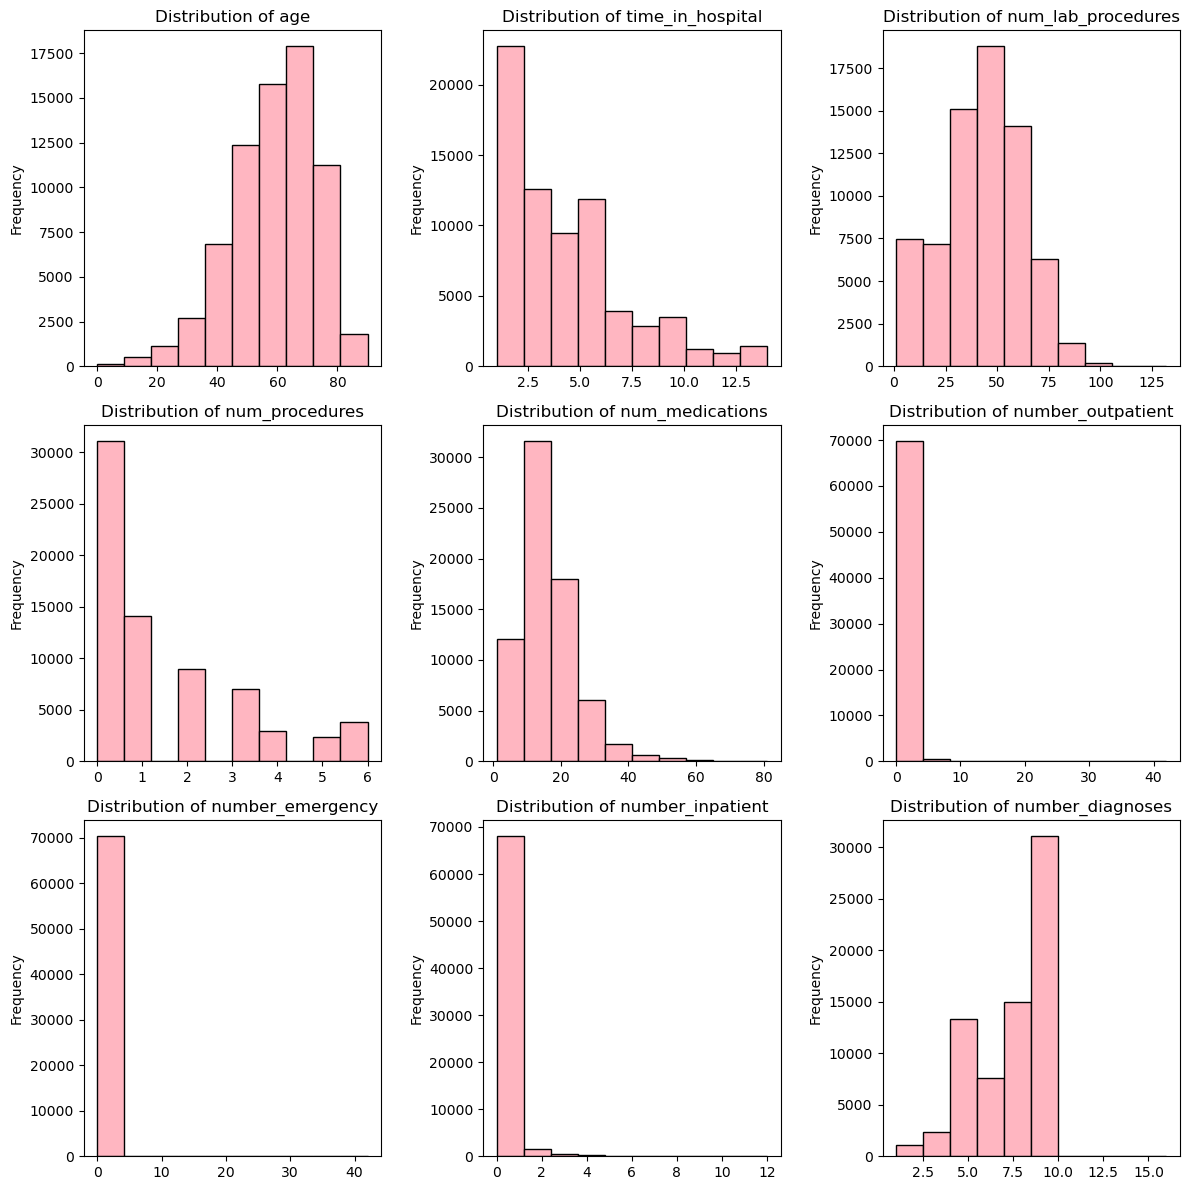

In [51]:
# Histograms for numeric variables
numeric_columns = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
plt.figure(figsize = (12,12))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i+1)
    plt.hist(diabetes[col], color = 'lightpink', edgecolor = 'black')
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
plt.tight_layout()

In [52]:
# number_outpatient, number_emergency, and number_inpatient have very small counts
# As they all relate, I will combine them into one column
diabetes['num_visits'] = diabetes['number_outpatient'] + diabetes['number_inpatient'] + diabetes['number_emergency']
diabetes.drop(columns=['number_outpatient', 'number_inpatient', 'number_emergency'], inplace=True)

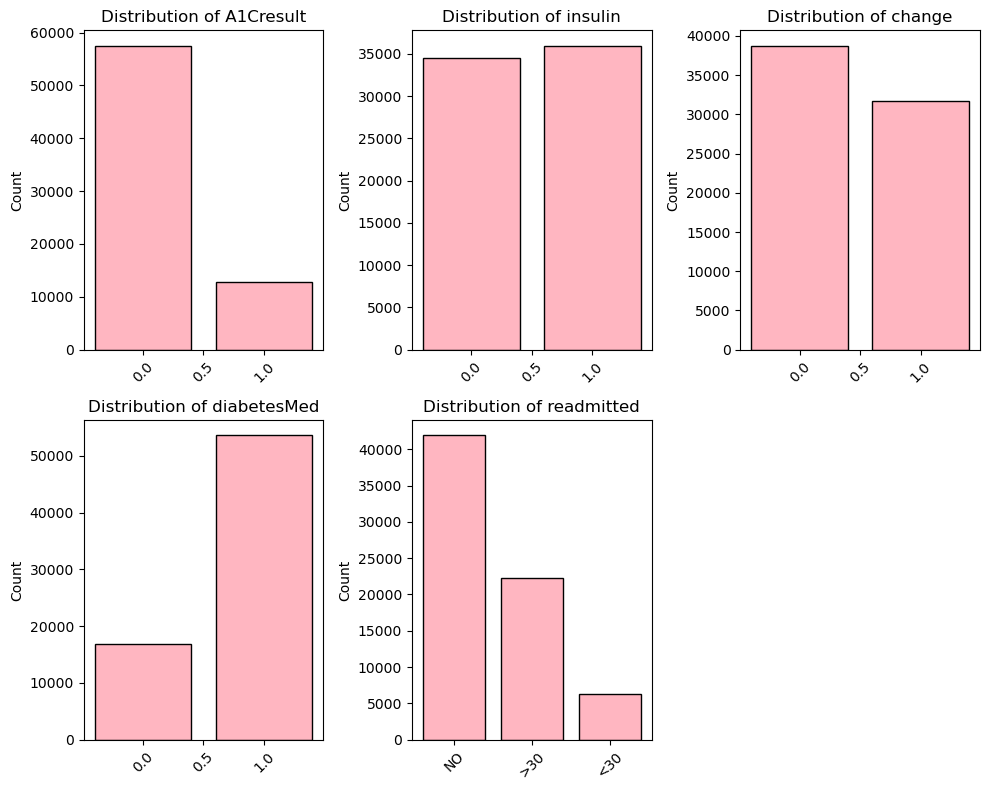

In [53]:
# Bar plots for binary variables (not medications)
binary_columns = ['A1Cresult', 'insulin', 'change', 'diabetesMed', 'readmitted']
plt.figure(figsize = (10, 8))
plot_cat(binary_columns, 2, 3)
plt.tight_layout()

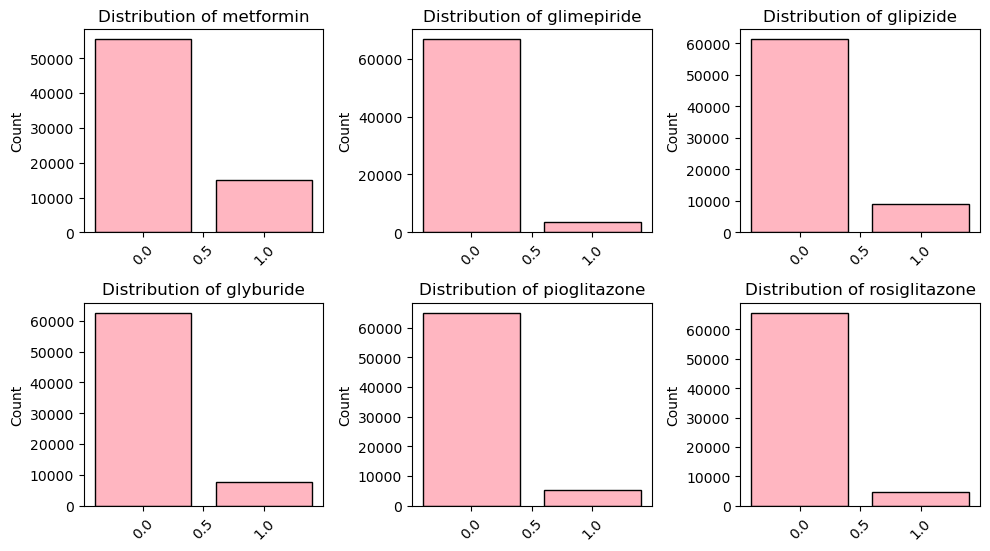

In [54]:
# Bar plots for binary variables (medications)
binary_columns = ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone']
plt.figure(figsize = (10, 8))
plot_cat(binary_columns, 3, 3)
plt.tight_layout()

## Logistic Regression Model
Fit a logistic regression model and evaluate its performance

In [55]:
# Make outcome a binary variable
diabetes['readmitted'] = diabetes['readmitted'].map({'NO': 0, '<30': 1, '>30': 1})

In [56]:
# Create X and y
X = diabetes.drop(['readmitted'], axis=1)
y = diabetes['readmitted']

In [57]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 0, 
                                                    stratify = y)

In [58]:
# Choose variables I want to include in model
variables = ['race', 
            'gender', 
            'age', 
            'admission_type', 
            'discharge_disposition', 
            'admission_source', 
            'time_in_hospital',
            'num_lab_procedures', 
            'num_procedures', 
            'num_medications', 
            'num_visits',
            'number_diagnoses',
            'A1Cresult',
            'change',
            'diabetesMed',
            'metformin',
            'glipizide', 
            'glyburide', 
            'insulin',
            'diag_1']
# Not including diag_2 and diag_3 because they have so many categories and already including diag_1
X_train = X_train.loc[:, variables]
X_test = X_test.loc[:, variables]

In [59]:
# One hot encode categorical (non binary) for logistic regression
cat_variables = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(cat_variables)
X_train = pd.get_dummies(X_train, columns=cat_variables, drop_first = True).astype(int)
X_test = pd.get_dummies(X_test, columns=cat_variables, drop_first = True).astype(int)

['race', 'gender', 'admission_type', 'discharge_disposition', 'admission_source', 'diag_1']


In [60]:
# Scale numeric variables in training set, leave binary/dummy variables
numeric = ['age', 'num_medications', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'number_diagnoses']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric])
X_train_scaled = pd.DataFrame(X_train_scaled, columns = numeric, index = X_train.index)
X_train = X_train.drop(columns = numeric).join(X_train_scaled)

# Do not refit for test data, just scale from training data to prevent data leakage
X_test_scaled = scaler.transform(X_test[numeric])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = numeric, index = X_test.index)
X_test = X_test.drop(columns = numeric).join(X_test_scaled)

Text(0.5, 1.0, 'Correlation Matrix')

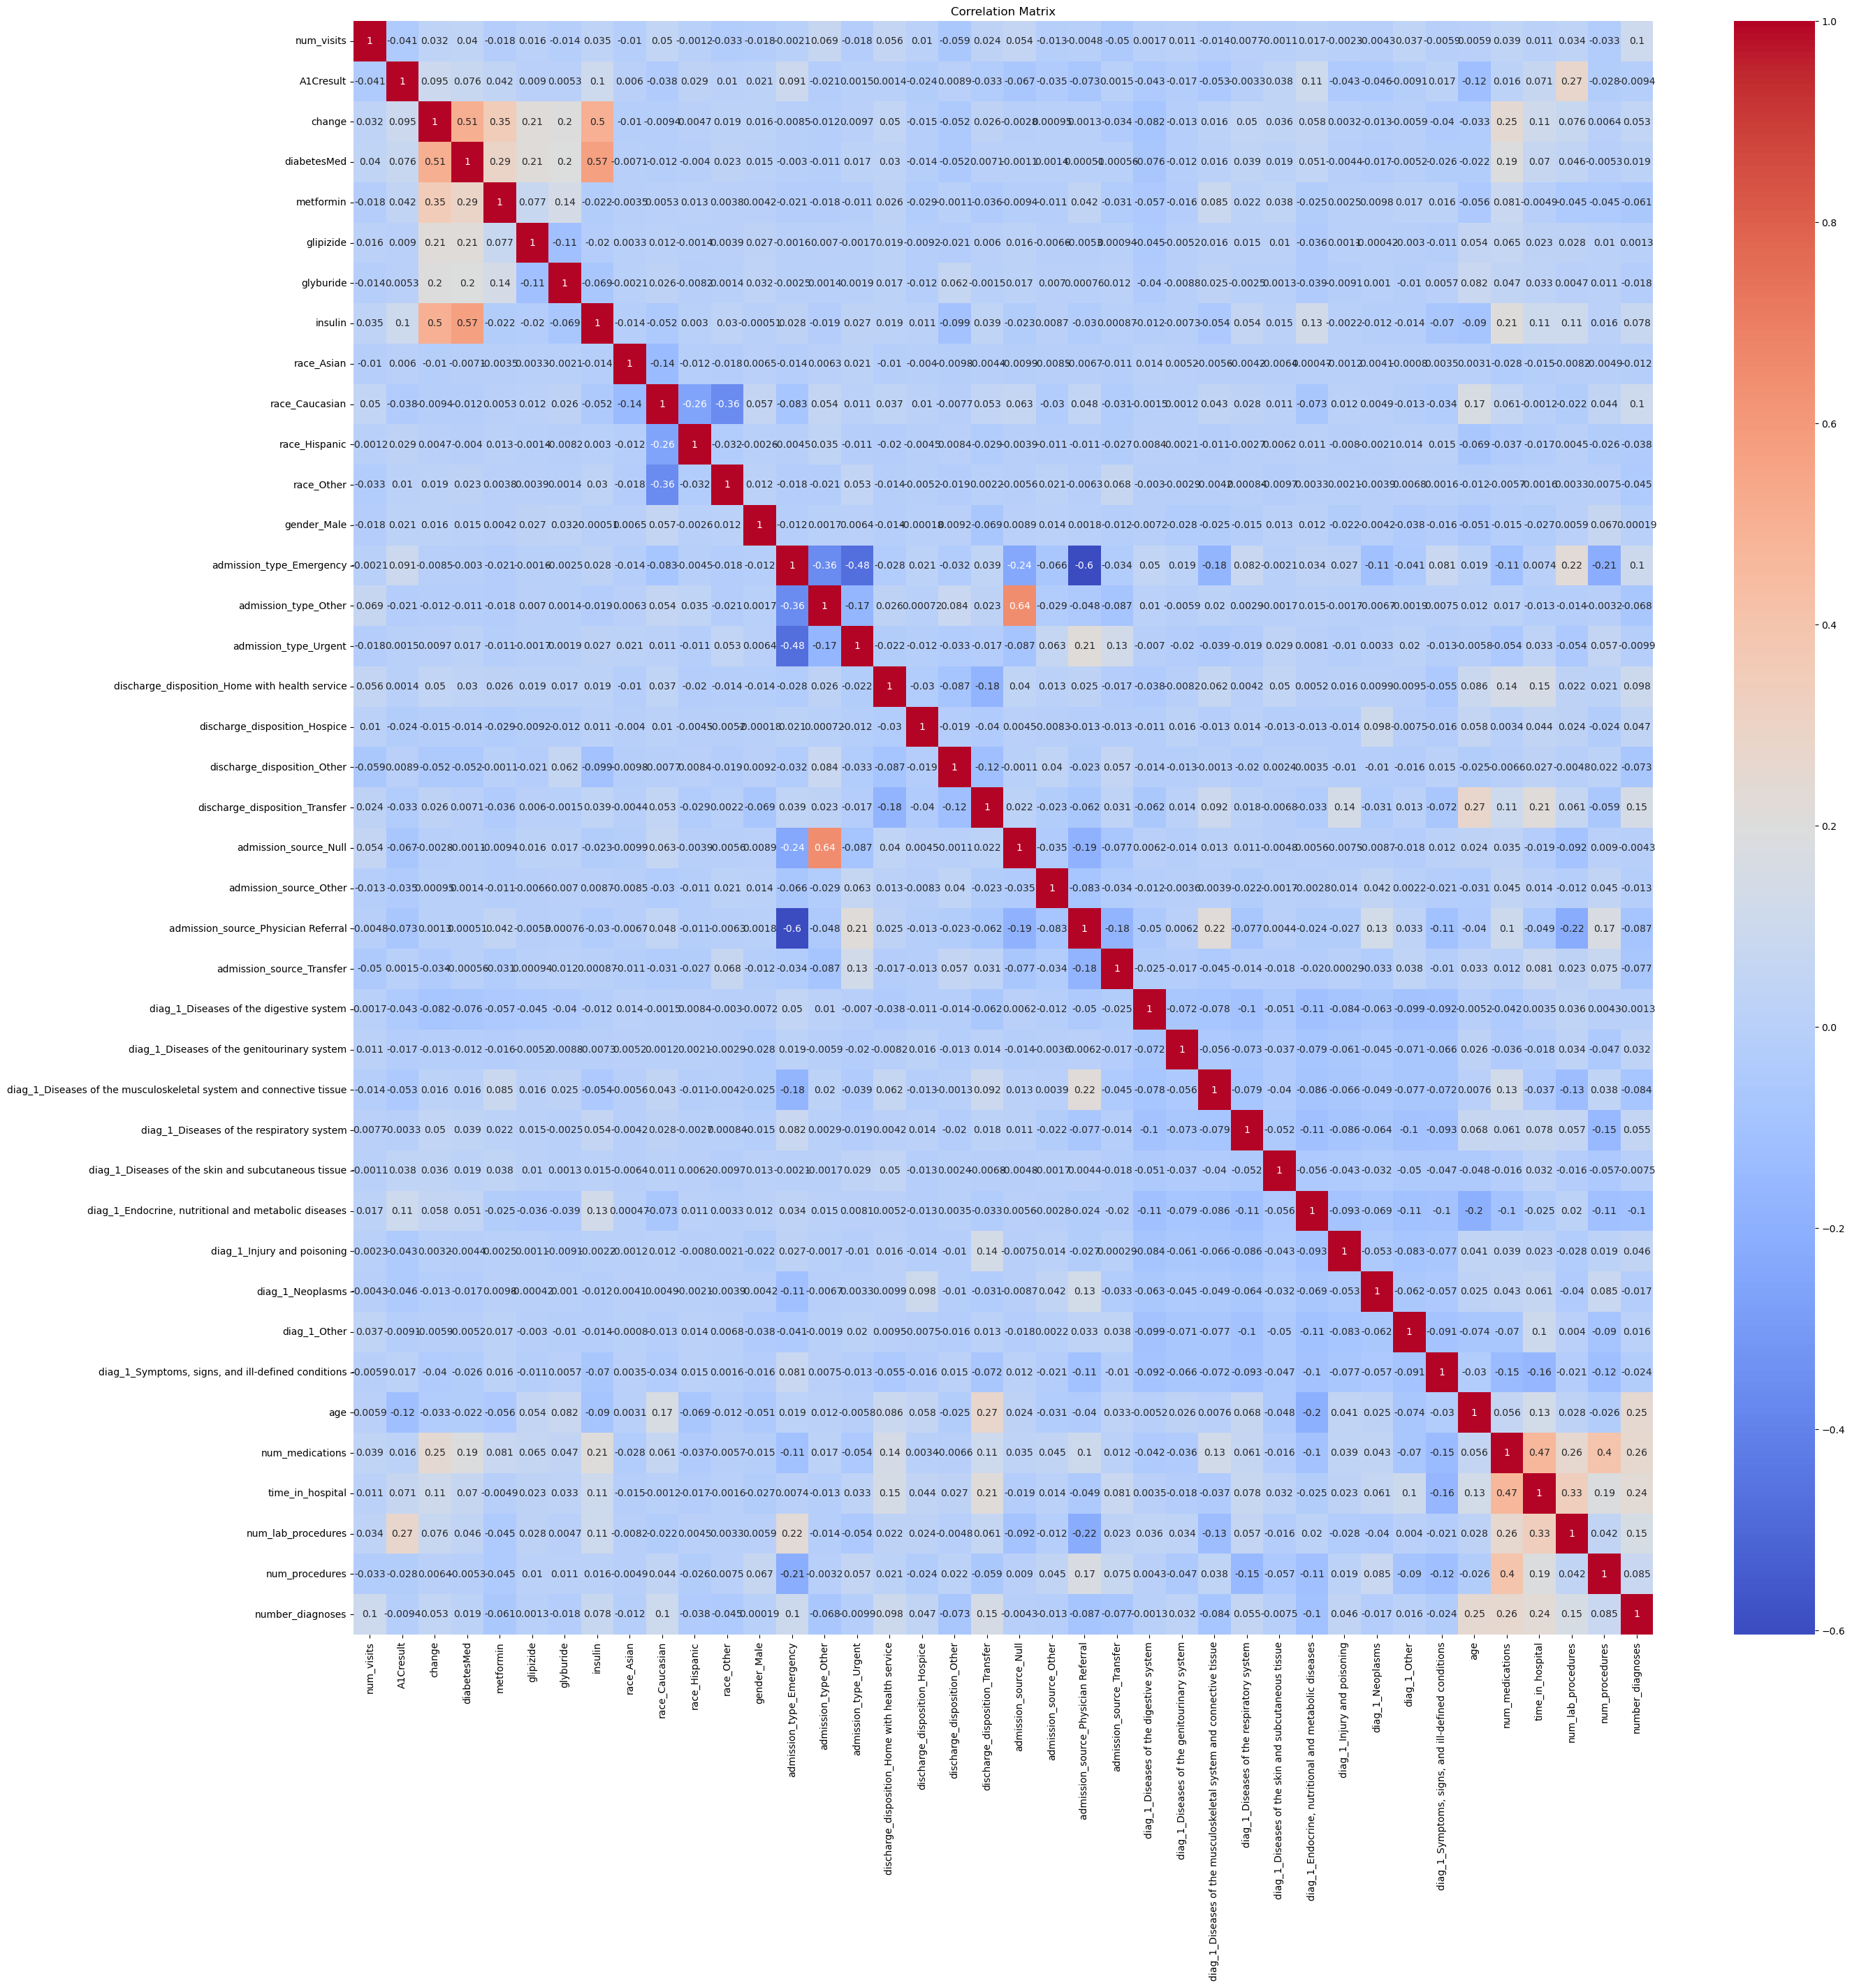

In [61]:
# Corrrelation matrix for selected variables only on training data (prevent data leakage)
corr_matrix = X_train.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

I am choosing to drop diabetesMed because it has high correlation with metformin and insulin. Because metformin and insulin are both medicines for diabetes, this is redundant information. I am keeping the rest of the correlated variables because they all provide distinct, meaningful information.

In [62]:
# Drop 'diabetesMed'
X_train = X_train.drop(['diabetesMed'], axis=1)
X_test = X_test.drop(['diabetesMed'], axis=1)

In [63]:
# Investigate the distribution of the outcome class
sum(y_train) / len(y_train)

0.4051185574329121

In [64]:
# Inialize model
logit = LogisticRegression(max_iter = 1000)
logit.fit(X_train, y_train)
y_train_pred = logit.predict(X_train)
accuracy_training = accuracy_score(y_train, y_train_pred)
print('Training Set Accuracy: ', accuracy_training)

Training Set Accuracy:  0.6192851057787875


In [65]:
# Predict on test set
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:, 1]

In [66]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not Readmitted', 'Actually Readmitted'],
                            columns = ['Predicted Not Readmitted', 'Predicted Readmitted'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
                         Predicted Not Readmitted  Predicted Readmitted
Actually Not Readmitted                      7356                  1024
Actually Readmitted                          4320                  1387

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.88      0.73      8380
           1       0.58      0.24      0.34      5707

    accuracy                           0.62     14087
   macro avg       0.60      0.56      0.54     14087
weighted avg       0.61      0.62      0.57     14087

Accuracy: 0.6206431461631291
ROC AUC: 0.6372051573393308


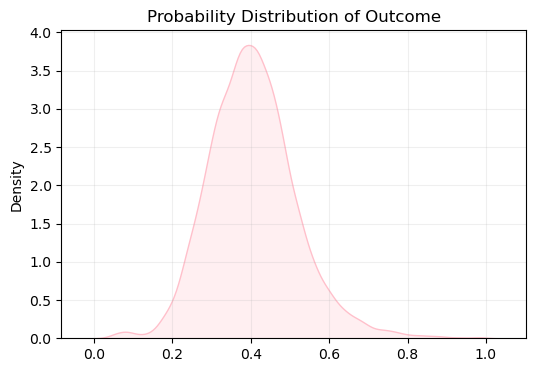

In [67]:
# Plot probabilities
plt.figure(figsize=(6,4))
sns.kdeplot(y_prob, fill=True, color='pink')
plt.title('Probability Distribution of Outcome')
plt.grid(alpha = 0.2)

In [68]:
def plot_roc(fpr, tpr, auc):
    """
    Plot ROC curve
    """
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='pink')
    plt.title(f'ROC Curve (AOC = {auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.grid(alpha = 0.2)

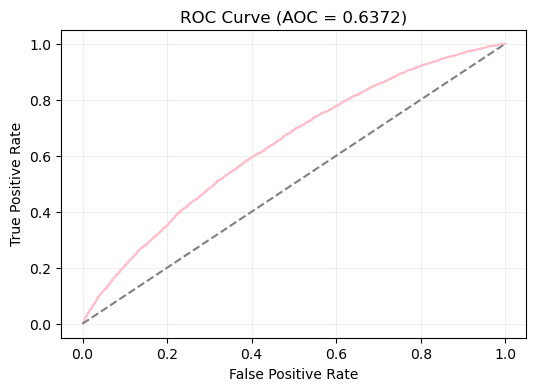

In [69]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plot_roc(fpr, tpr, roc_auc)

In [70]:
# Make table for variance inflation factor to see multicolinearity
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data.sort_values('VIF', ascending=False).head(20))

                                              Feature       VIF
8                                      race_Caucasian  4.463742
12                           admission_type_Emergency  4.005482
2                                              change  3.485252
6                                             insulin  3.215485
21                admission_source_Physician Referral  2.493347
13                               admission_type_Other  2.423458
19                              admission_source_Null  2.071615
11                                        gender_Male  1.876044
34                                    num_medications  1.866734
14                              admission_type_Urgent  1.791538
18                     discharge_disposition_Transfer  1.619117
35                                   time_in_hospital  1.588777
3                                           metformin  1.575446
28  diag_1_Endocrine, nutritional and metabolic di...  1.514219
37                                     n

As all of the VIF values are less than 5.5, this indicates that there is no serious multicolinearity - no features were removed based on multicollinearity.

## Random Forest

In [71]:
# Initialize and fit the baseline model
rf_baseline = RandomForestClassifier(random_state = 42).fit(X_train, y_train)

In [72]:
# Score baseline decision tree model on training and test set
print('Baseline Training Accuracy: ', rf_baseline.score(X_train, y_train))
y_prob = rf_baseline.predict_proba(X_test)
y_pred = rf_baseline.predict(X_test)
print('Baseline Test Accuracy: ', rf_baseline.score(X_test, y_test))

Baseline Training Accuracy:  0.9999290075252023
Baseline Test Accuracy:  0.6247604174061191


Due to the computational demands of cross-validated hyperparameter tuning, I ran the cross validation on a high-performance (HPC) environment. The scripts to run this are in the 'cross_validation' folder.

In [75]:
# Load hyperparameters tuned with cross validation
best_params_rf = open('cross_validation/best_params_rf.txt')
print(best_params_rf.read())

{
    "best_params": {
        "n_estimators": 500,
        "min_samples_split": 10,
        "min_samples_leaf": 5,
        "max_features": "log2",
        "max_depth": 25,
        "criterion": "gini",
        "class_weight": null
    }
}


In [76]:
# Optimized model with best hyperparameters
rf = RandomForestClassifier(n_estimators = 500, 
                            max_depth = 25,
                            min_samples_split = 10,
                            min_samples_leaf = 5,
                            criterion = 'gini',
                            max_features = 'log2',
                            class_weight = None,
                            random_state = 42)
rf.fit(X_train, y_train)

# Results on training set
print('Training Set Accuracy: ', rf.score(X_train, y_train))

Training Set Accuracy:  0.7734807610393298


In [77]:
# Make tuned predictions on test set
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

In [78]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not Readmitted', 'Actually Readmitted'],
                            columns = ['Predicted Not Readmitted', 'Predicted Readmitted'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
                         Predicted Not Readmitted  Predicted Readmitted
Actually Not Readmitted                      7269                  1111
Actually Readmitted                          4016                  1691

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74      8380
           1       0.60      0.30      0.40      5707

    accuracy                           0.64     14087
   macro avg       0.62      0.58      0.57     14087
weighted avg       0.63      0.64      0.60     14087

Accuracy: 0.6360474196067296
ROC AUC: 0.6605919623892778


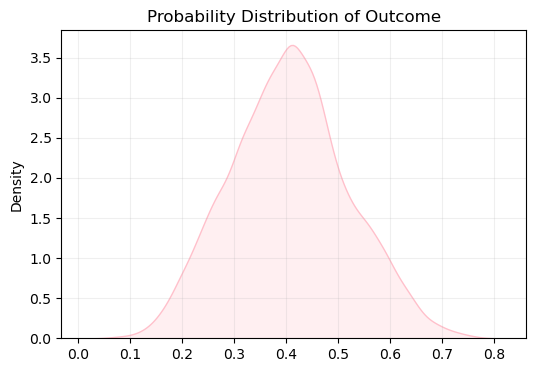

In [79]:
# Plot probabilities
plt.figure(figsize=(6,4))
sns.kdeplot(y_prob, fill=True, color='pink')
plt.title('Probability Distribution of Outcome')
plt.grid(alpha = 0.2)

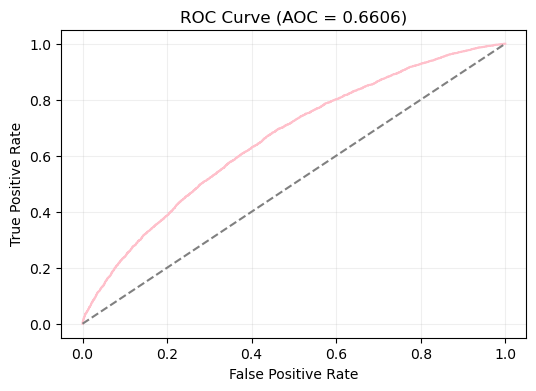

In [80]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plot_roc(fpr, tpr, roc_auc)

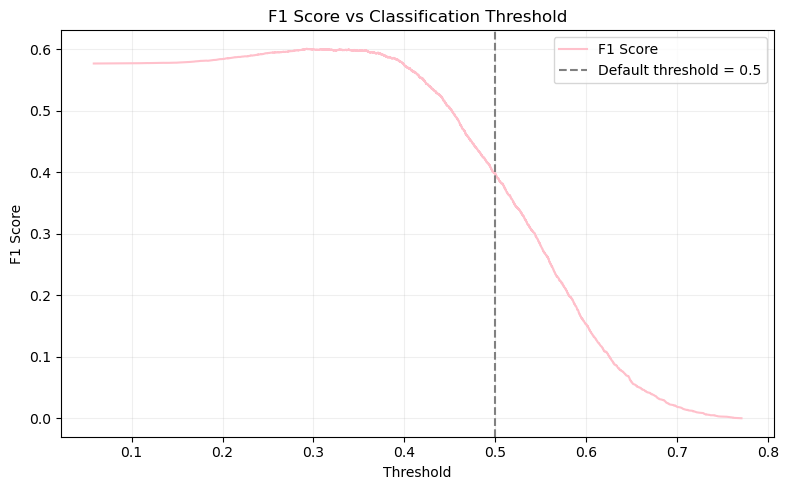

In [81]:
# Plot F1-Threshold curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
plt.figure(figsize = (8,5))
plt.plot(thresholds, f1[:-1], label = 'F1 Score', color = 'pink')
plt.axvline(x = 0.5, color = 'gray', linestyle = '--', label = 'Default threshold = 0.5')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Classification Threshold')
plt.legend()
plt.grid(alpha = 0.2)
plt.tight_layout()

In [82]:
# Find max F1 score
best_threshold = thresholds[np.argmax(f1)]
best_threshold

0.2925312033018148

In [83]:
# Redo the predictions at that threshold
y_pred_new = (y_prob >= best_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_new)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not Readmitted', 'Actually Readmitted'],
                            columns = ['Predicted Not Readmitted', 'Predicted Readmitted'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_new))
print("Accuracy:", accuracy_score(y_test, y_pred_new))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
                         Predicted Not Readmitted  Predicted Readmitted
Actually Not Readmitted                      1892                  6488
Actually Readmitted                           474                  5233

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.23      0.35      8380
           1       0.45      0.92      0.60      5707

    accuracy                           0.51     14087
   macro avg       0.62      0.57      0.48     14087
weighted avg       0.66      0.51      0.45     14087

Accuracy: 0.5057854759707532
ROC AUC: 0.6605919623892778


In [84]:
# Look at feature importances
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
importances_df = importances_df.sort_values(by = 'Importance', ascending = False)
print(importances_df.head(20))

                                           Feature  Importance
36                              num_lab_procedures    0.145186
34                                 num_medications    0.120430
0                                       num_visits    0.100616
35                                time_in_hospital    0.080603
38                                number_diagnoses    0.073877
33                                             age    0.070041
37                                  num_procedures    0.056304
11                                     gender_Male    0.025853
6                                          insulin    0.020119
2                                           change    0.018894
3                                        metformin    0.017667
8                                   race_Caucasian    0.016948
18                  discharge_disposition_Transfer    0.016562
12                        admission_type_Emergency    0.016100
21             admission_source_Physician Referral    0

#### SHAP Values

In [86]:
# Load in SHAP values
shap_values = joblib.load('shap_values/shap_values_rf.pkl')
print(shap_values.shape)

(14087, 39, 2)


In [87]:
# 14087: number of samples, 39: number of features, 2: binary classes
# Only want the shap_values for class 1 (readmitted)
shap_values_1 = shap_values[:, :, 1]
shap_values_1.shape

(14087, 39)

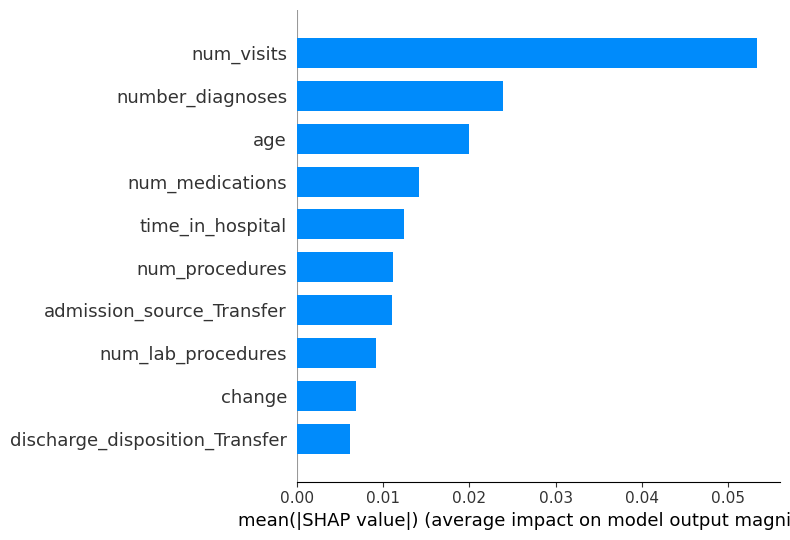

In [88]:
# Visualise through a bar plot
shap.summary_plot(shap_values_1, X_test, plot_type = "bar", max_display = 10)

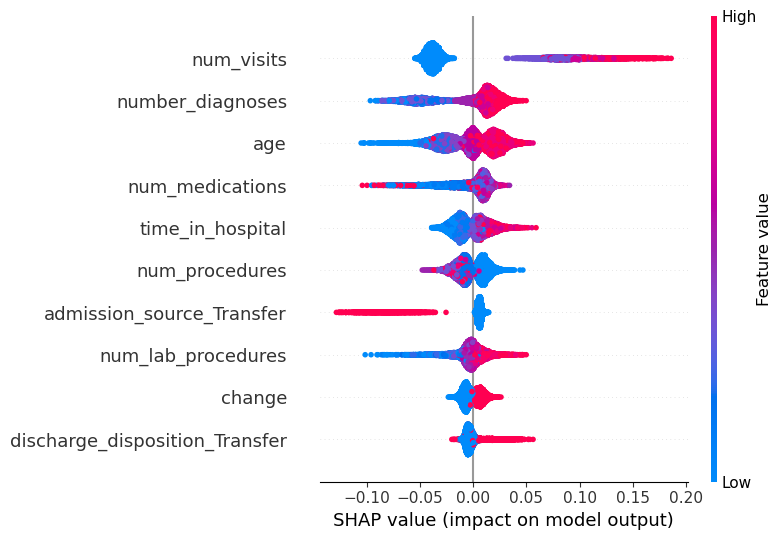

In [89]:
# Visualise through a beeswarm plot
shap.summary_plot(shap_values_1, X_test, max_display = 10)

## XGBoost

In [90]:
# Remove or replace special characters in column names because xgboost cannot handle
X_train.columns = X_train.columns.str.replace(r'[{}\[\]":,]', '', regex=True)
X_test.columns = X_test.columns.str.replace(r'[{}\[\]":,]', '', regex=True)

In [91]:
# Initialize and fit the baseline model
xgb_baseline = XGBClassifier(random_state = 42).fit(X_train, y_train)

# Score baseline decision tree model on training and test set
print('Baseline Training Accuracy: ', xgb_baseline.score(X_train, y_train))
y_prob = xgb_baseline.predict_proba(X_test)[:, 1]
y_pred = xgb_baseline.predict(X_test)
print('Baseline Test Accuracy: ', xgb_baseline.score(X_test, y_test))

Baseline Training Accuracy:  0.7015121397131904
Baseline Test Accuracy:  0.6290196635195571


In [92]:
# Split training set into train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                      y_train, 
                                                      test_size = 0.2, 
                                                      random_state = 42, 
                                                      stratify = y_train)

In [93]:
# Calculate class imbalance ratio
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

Due to the computational demands of cross-validated hyperparameter tuning, I ran the cross validation on a high-performance (HPC) environment. The scripts to run this are in the 'cross_validation' folder.

In [94]:
# Load hyperparameters tuned with cross validation
best_params_xgb = open('cross_validation/best_params_xgb.txt')
print(best_params_xgb.read())

{
    "best_params": {
        "subsample": 0.6,
        "scale_pos_weight": 0.734206606501358,
        "n_estimators": 500,
        "min_child_weight": 1,
        "max_depth": 4,
        "learning_rate": 0.05,
        "colsample_bytree": 1.0
    }
}


In [95]:
# Optimised model with best hyperparameters
xgb = XGBClassifier(scale_pos_weight = 0.7532200122667134,
                    n_estimators = 500,
                    min_child_weight = 1,
                    max_depth = 4,
                    learning_rate = 0.05,
                    subsample = 0.6,
                    colsample_bytree = 1.0,
                    eval_metric = 'logloss',
                    random_state = 42,
                    early_stopping_rounds = 10)

xgb.fit(X_train, 
        y_train,
        eval_set = [(X_valid, y_valid)],
        verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [96]:
# Predict on test set
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

In [97]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not Readmitted', 'Actually Readmitted'],
                            columns = ['Predicted Not Readmitted', 'Predicted Readmitted'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
                         Predicted Not Readmitted  Predicted Readmitted
Actually Not Readmitted                      7814                   566
Actually Readmitted                          4705                  1002

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.93      0.75      8380
           1       0.64      0.18      0.28      5707

    accuracy                           0.63     14087
   macro avg       0.63      0.55      0.51     14087
weighted avg       0.63      0.63      0.56     14087

Accuracy: 0.6258252289344786
ROC AUC: 0.6590902162189967


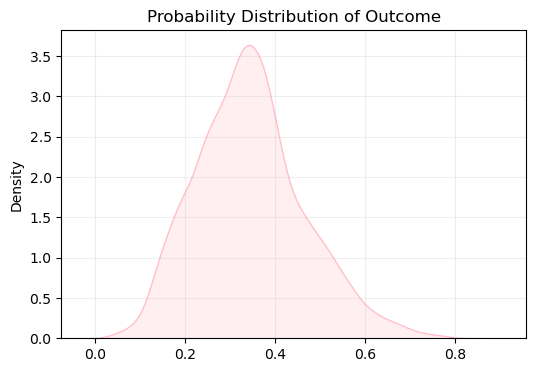

In [98]:
# Plot probabilities
plt.figure(figsize=(6,4))
sns.kdeplot(y_prob, fill=True, color='pink')
plt.title('Probability Distribution of Outcome')
plt.grid(alpha = 0.2)

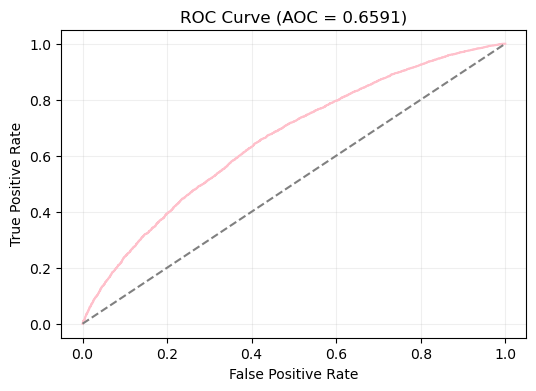

In [99]:
# Plot ROC curve
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plot_roc(fpr, tpr, roc_auc)

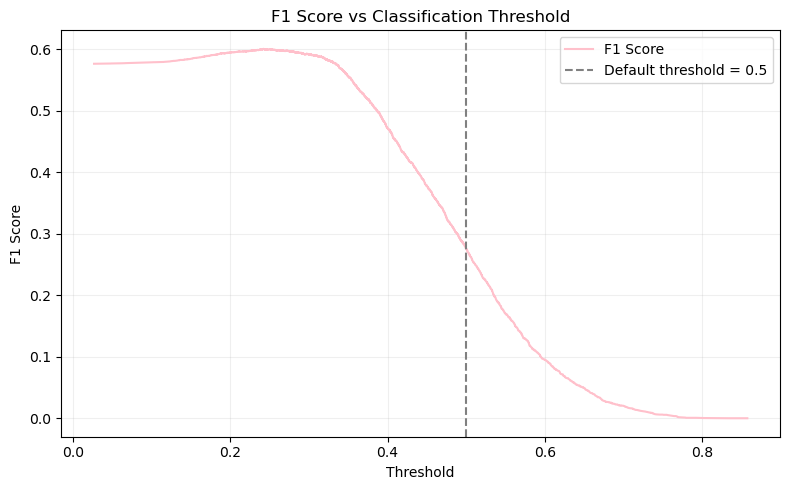

In [100]:
# Plot F1-Threshold curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
plt.figure(figsize = (8,5))
plt.plot(thresholds, f1[:-1], label = 'F1 Score', color = 'pink')
plt.axvline(x = 0.5, color = 'gray', linestyle = '--', label = 'Default threshold = 0.5')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Classification Threshold')
plt.legend()
plt.grid(alpha = 0.2)
plt.tight_layout()

In [101]:
# Find max F1 score
best_threshold = thresholds[np.argmax(f1)]
best_threshold

0.24207893

In [102]:
# Redo the predictions at that threshold
y_pred_new = (y_prob >= best_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_new)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not Readmitted', 'Actually Readmitted'],
                            columns = ['Predicted Not Readmitted', 'Predicted Readmitted'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_new))
print("Accuracy:", accuracy_score(y_test, y_pred_new))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
                         Predicted Not Readmitted  Predicted Readmitted
Actually Not Readmitted                      2249                  6131
Actually Readmitted                           622                  5085

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.27      0.40      8380
           1       0.45      0.89      0.60      5707

    accuracy                           0.52     14087
   macro avg       0.62      0.58      0.50     14087
weighted avg       0.65      0.52      0.48     14087

Accuracy: 0.5206218499325619
ROC AUC: 0.6590902162189967


In [103]:
# Feature importances
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_})
importances_df = importances_df.sort_values(by = 'Importance', ascending = False)
print(importances_df.head(20))

                                              Feature  Importance
0                                          num_visits    0.121093
16                      discharge_disposition_Hospice    0.049973
22                          admission_source_Transfer    0.044116
38                                   number_diagnoses    0.043195
13                               admission_type_Other    0.032335
30                                   diag_1_Neoplasms    0.031152
33                                                age    0.029495
2                                              change    0.026943
10                                         race_Other    0.025617
21                admission_source_Physician Referral    0.024486
18                     discharge_disposition_Transfer    0.024476
3                                           metformin    0.024330
15     discharge_disposition_Home with health service    0.023655
14                              admission_type_Urgent    0.022551
36        

#### SHAP Values

In [104]:
# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

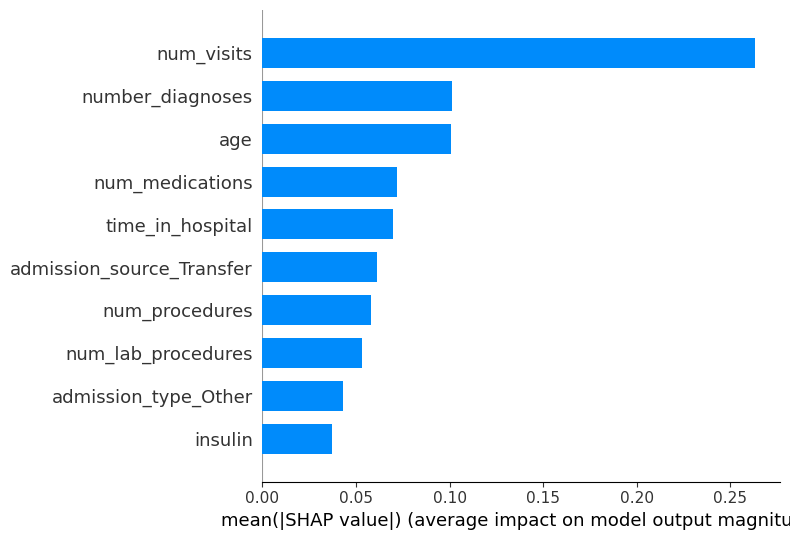

In [105]:
# Visualise through a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display = 10)

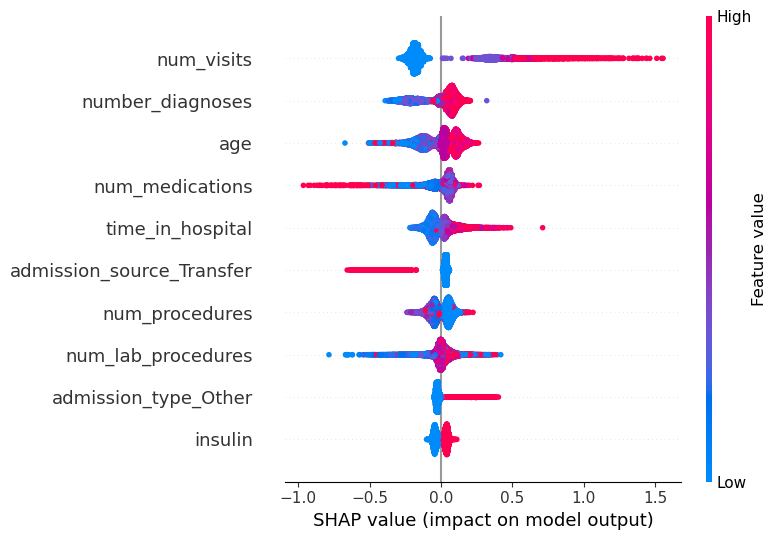

In [106]:
# Visualise through a beeswarm plot
shap.summary_plot(shap_values, X_test, max_display = 10)